Import libraries

In [1]:
import re, os
import unicodedata
import json

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score



from requests import get
from bs4 import BeautifulSoup

from wordcloud import WordCloud

import acquire_jg
import prepare_jag


plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

pd.set_option('display.max_rows', 200)


---

## Acquire Data

Briefly, we used Beautiful Soup to scrape the repository names from `github.com\apple`. Then generated a Github API key and used the `acquire.py` file provided to use the Github API to extract the `README` text and language name.

For speed and convenience, we cached a `.json` file with the results from our `acquire.py` file to load.


In [2]:
# Load cached data
df = pd.read_json('data.json')

## Prepare Data

---

We use a `prepare.py` file with helper functions to perform the following preparation steps:

1. Rename columns where appropriate.
2. Manually assign README languages to 7 of 8 files with null languages. The 8th file was kept and assigned a language of other.
3. Dropped four rows with missing `README` files. (There were no additional null values in the dataset at this point)
4. Add columns for cleaned, stemmed, and lemmatized text in addition to the original. Use custom stopword list to remove low-value, high-frequency words.
5. Added a column for classification target based on language
   1. Swift = swift
   2. Python = python
   3. C++ or C = c
   4. Anything else (including the 1 without a language) = other

Data was split into X/y targets and train / test sets in modeling.

**NOTE:** Only univariate exploration and statistics were performed, so we explored the entire dataset available. Since we were not fitting and imputing or looking at bivariate relationships, we did not need to split our data prior to exploring it.

In [3]:
# Call the prepare article function with extra user-defined stopwords
df = prepare_jag.prep_article_data(df, 'original', extra_words=['&#9;', "'", '1', '0', 'use', 'file', 'build', 'test', 'code'])

Renamed 'readme_content' column to 'original'
Manually assigned seven languages to null files.
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Dropped four rows with missing README files
Added column with language target category
Data preparation complete


Confirm language and pooled target language counts add up:

In [4]:
# Language valuecounts
df.language.value_counts()

Swift               69
Python              38
C++                 13
C                   10
JavaScript           3
LLVM                 2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
Name: language, dtype: int64

In [5]:
# Combined language family value counts
df.target.value_counts()

swift     69
python    38
c         23
other     17
Name: target, dtype: int64

They add up. (1 missing language still, categorized as other for target is why the other is 17 while only 16 above)

---

## Explore

Let's examine the distribution of languages in the dataset

In [6]:
# Look at distribution of languages
language = pd.concat([df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1)
language.columns = ['n', 'percent']
language

,n,percent
Swift,69,0.472603
Python,38,0.260274
C++,13,0.089041
C,10,0.068493
JavaScript,3,0.020548
LLVM,2,0.013699
Java,2,0.013699
Jupyter Notebook,2,0.013699
HTML,2,0.013699
Dockerfile,1,0.006849


In [7]:
# Look at Categorized languages
tlanguage = pd.concat([df.target.value_counts(), df.target.value_counts(normalize = True)], axis = 1)
tlanguage.columns = ['n', 'percent']
tlanguage

,n,percent
swift,69,0.469388
python,38,0.258503
c,23,0.156463
other,17,0.115646


<AxesSubplot:ylabel='n'>

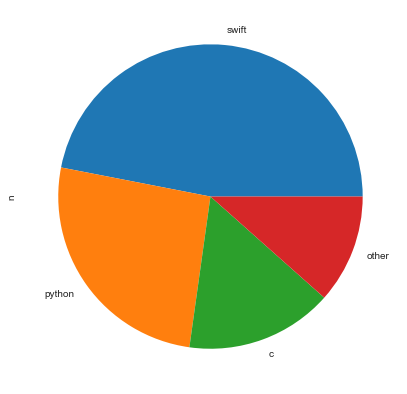

In [42]:
tlanguage.n.plot.pie()

Slight imbalance in the underlying data, but nothing so large that would hamper modeling.

Make word lists by languages from lemmatized words


In [8]:
#Make word lists by targets from lemmatized words
swift_words = ' '.join(df[df.target == 'swift'].lemmatized).split()
python_words = ' '.join(df[df.target == 'python'].lemmatized).split()
c_words = ' '.join(df[df.target == 'c'].lemmatized).split()
other_words = ' '.join(df[df.target == 'other'].lemmatized).split()
all_words = ' '.join(df.lemmatized).split()

In [9]:
# Look at word list lengths
print('Swift words: '+str(len(swift_words)))
print('Python words: '+str(len(python_words)))
print('C words: '+str(len(c_words)))
print('Other words: '+str(len(other_words)))
print('All words: '+str(len(all_words)))


Swift words: 29163
Python words: 15767
C words: 7681
Other words: 4290
All words: 56901


In [10]:
# Calculate word frequencies
swift_freq = pd.Series(swift_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

Look at the 20 most common words and their frequency counts by language.

In [11]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, swift_freq, python_freq, c_freq, other_freq], axis = 1, sort = True)
                .set_axis(['all', 'swift', 'python', 'c', 'other'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(20)

,all,swift,python,c,other
swift,981,783,40,122,36
package,383,302,21,47,13
project,371,218,68,49,36
using,324,183,77,45,19
data,273,97,122,30,24
library,272,207,20,40,5
run,271,140,81,26,24
example,228,117,70,27,14
used,219,86,87,33,13
version,218,134,42,28,14


In [40]:
df.head()

,repo,language,target,original,clean,stemmed,lemmatized
0,apple/llvm-project,LLVM,other,# Apple's fork of llvm-project\n\nThis is Appl...,apple fork llvmproject apple fork llvmproject ...,appl fork llvmproject thi appl fork llvmprojec...,apple fork llvmproject apple fork llvmproject ...
1,apple/swift-argument-parser,Swift,swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
3,apple/swift,C++,c,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
4,apple/sourcekit-lsp,Swift,swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...


Lets vizualise the top 20 words by use in different languages

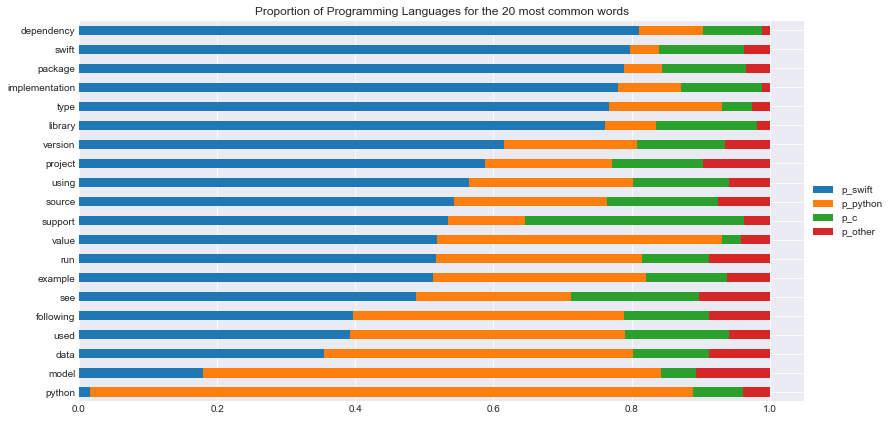

In [12]:
# figure out the percentage of language in words
(word_counts
 .assign(p_swift = word_counts.swift / word_counts['all'],
         p_python = word_counts.python / word_counts['all'],
         p_c = word_counts.c / word_counts['all'],
         p_other = word_counts.other / word_counts['all'])
 .sort_values(by = 'all')
 [['p_swift', 'p_python', 'p_c', 'p_other']]
 .tail(20)
 .sort_values('p_swift')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of Programming Languages for the 20 most common words');

## Look at bigrams by language

### Swift Bigrams

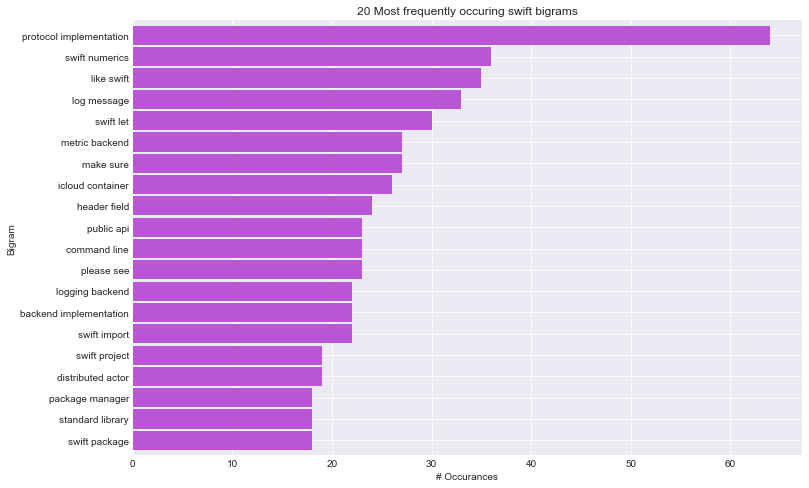

In [13]:
# Calculate bigrams
swift_bigrams = (pd.Series(nltk.ngrams(swift_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top Swift Bigrams
swift_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring swift bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = swift_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Python Bigrams

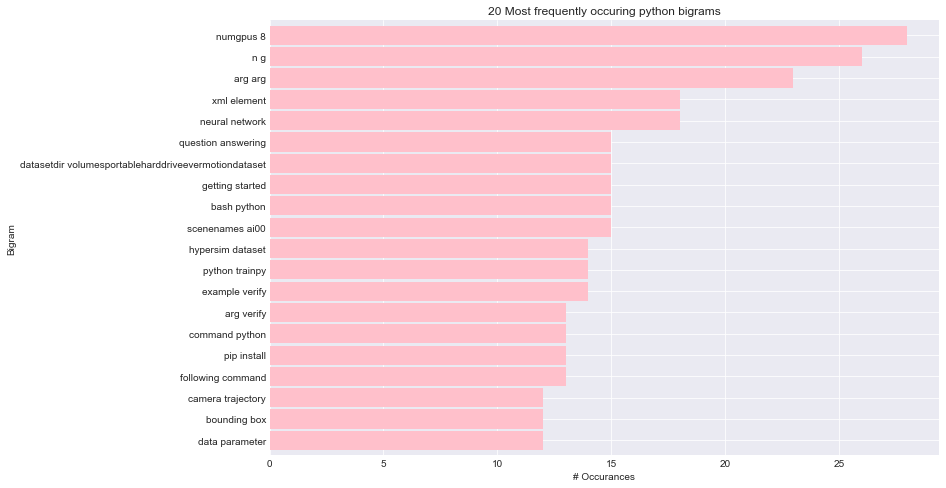

In [14]:
# Calculate python bigrams
python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

# Vizualize
python_bigrams.sort_values().plot.barh(color = 'pink', width = .9, figsize = (12, 8))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

### C Bigrams

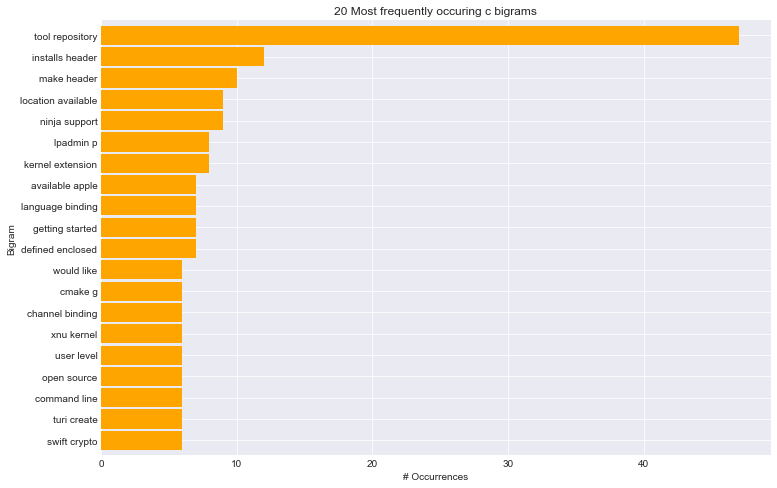

In [15]:
# Make c bigrams
c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

# Vizualize c bigrams
c_bigrams.sort_values().plot.barh(color = 'orange', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring c bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

### Other Language Bigrams

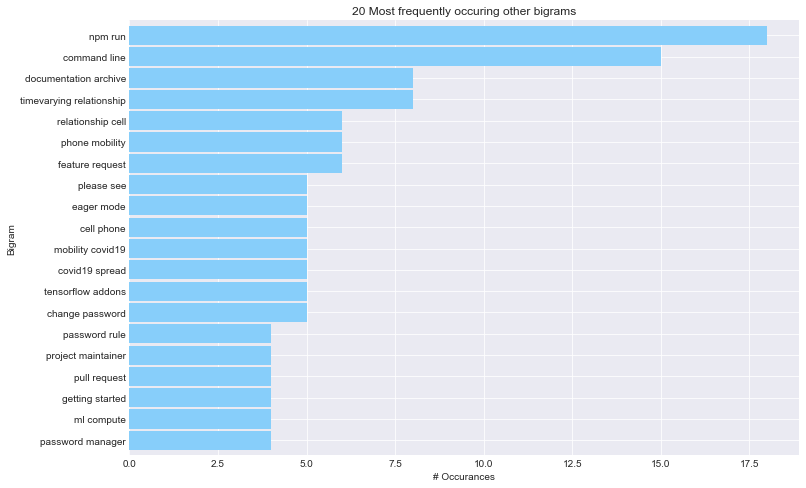

In [16]:
#Calculate bigrams
other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))
other_bigrams.sort_values().plot.barh(color = 'lightskyblue', width=.9, figsize=(12, 8))
#Vizualize bigrams
plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## Trigrams

### Swift

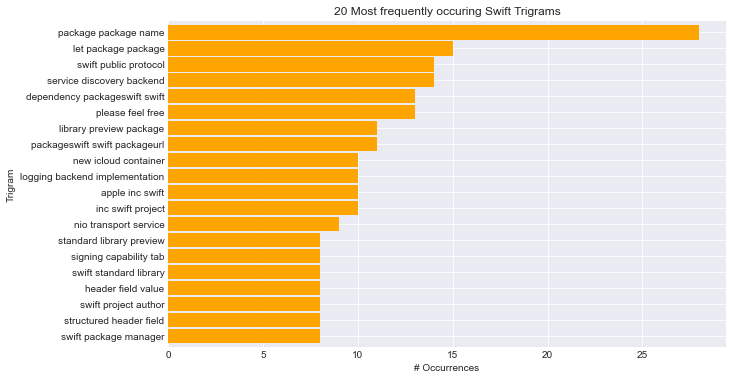

In [17]:
# Creating Swift trigrams:
top_20_swift_trigrams = (pd.Series(nltk.ngrams(swift_words, 3))
                      .value_counts()
                      .head(20))

top_20_swift_trigrams.head()
# Charting Swift trigrams:
top_20_swift_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Swift Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_swift_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

### Python

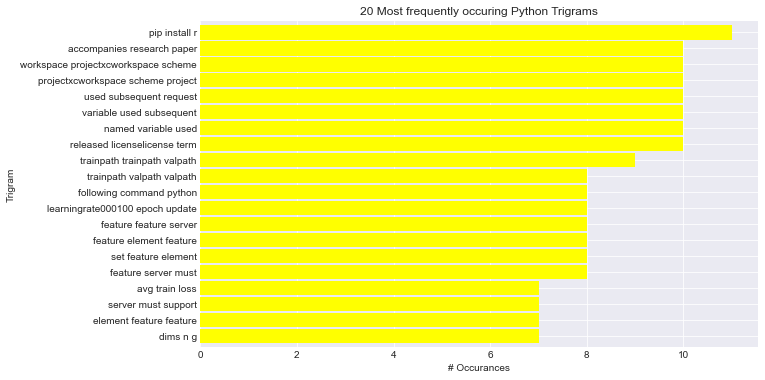

In [18]:
# Creating Python trigrams:
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts()
                      .head(20))

top_20_python_trigrams.head()
# Charting Python trigrams:
top_20_python_trigrams.sort_values().plot.barh(color='yellow', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

### C Family

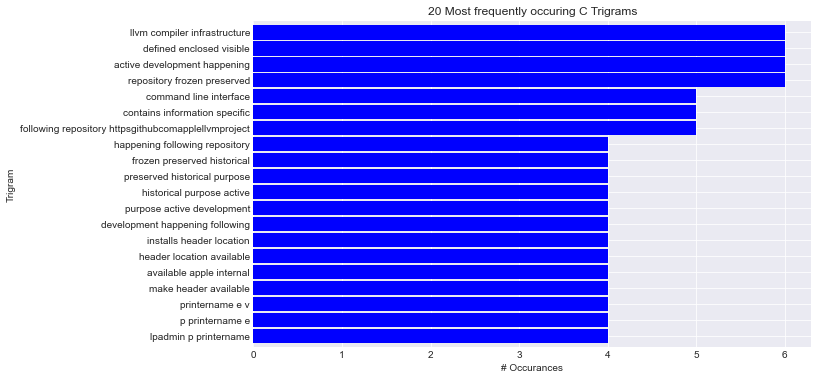

In [19]:
# Creating C trigrams:
top_20_c_trigrams = (pd.Series(nltk.ngrams(c_words, 3))
                      .value_counts()
                      .head(20))
# Charting C trigrams:
top_20_c_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

### Other

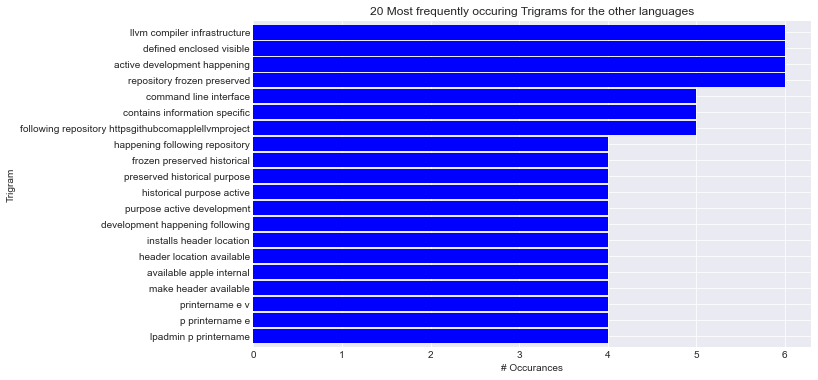

In [20]:
# Creating the 'Other' trigrams:
top_20_other_trigrams = (pd.Series(nltk.ngrams(other_words, 3))
                      .value_counts()
                      .head(20))
# Charting the 'Other' trigrams:
top_20_c_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Trigrams for the other languages')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

## Word Clouds

Vizualize most common words by language family

Text(0.5, 1.0, 'Other')

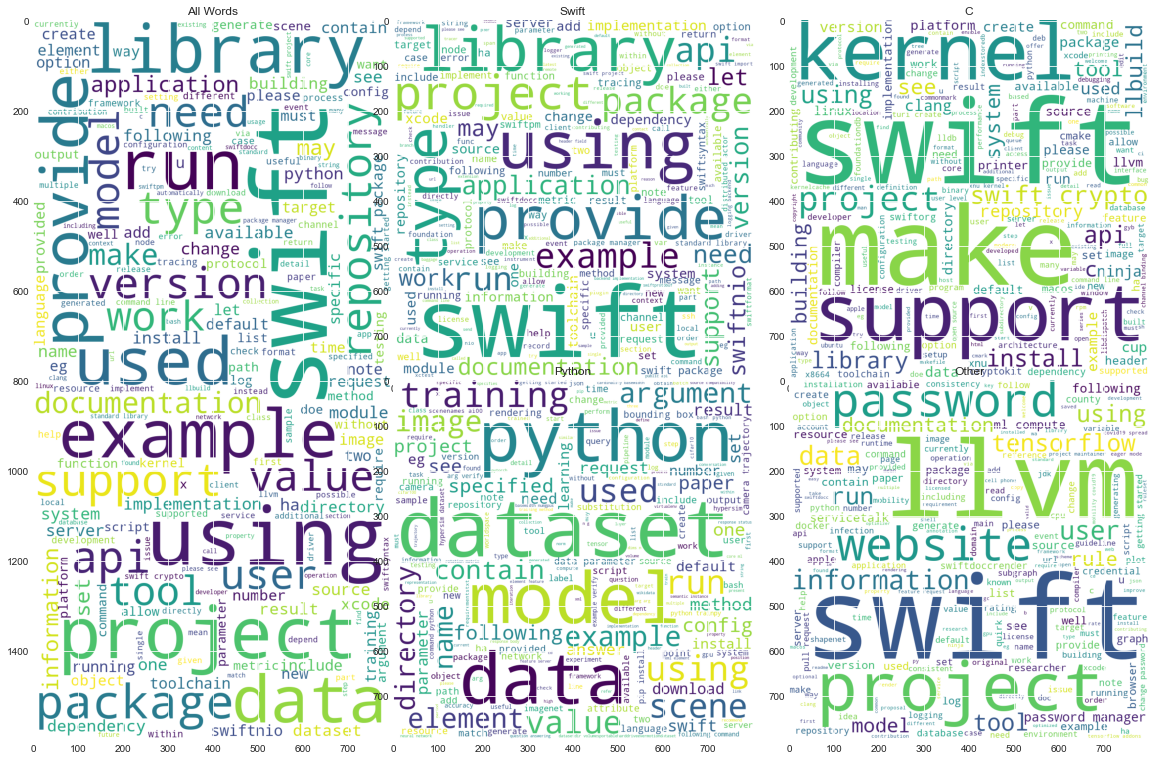

In [43]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 1600, width = 800).generate(' '.join(all_words))
swift_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(swift_words))
python_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(python_words))
c_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(c_words))
other_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(other_words))

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5]),
      plt.axes([1.05, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(swift_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(c_cloud)
axs[4].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Swift')
axs[2].set_title('Python')
axs[3].set_title('C')
axs[4].set_title('Other')



### Takeaways

- Interesting how common swift is in the 'other' word list
  - Sizes not to scale, look at raw counts
- Bigrams and trigrams make a lot of sense and could be useful to model on those instead of individual words

---

## Statistics

Is there a difference in readme length by language?

H0: There is no difference in mean character length by language

HA: There is a difference in mean character length by languagge

In [68]:
#Count word length of each original readme
def get_length(string):
    return len(string)
# Add column with length of original
df['original_length']=df.original.apply(get_length)
# Look at mean by language
df.groupby('target').original_length.mean()

target
c         4717.913043
other     3443.411765
python    5445.394737
swift     5845.666667
Name: original_length, dtype: float64

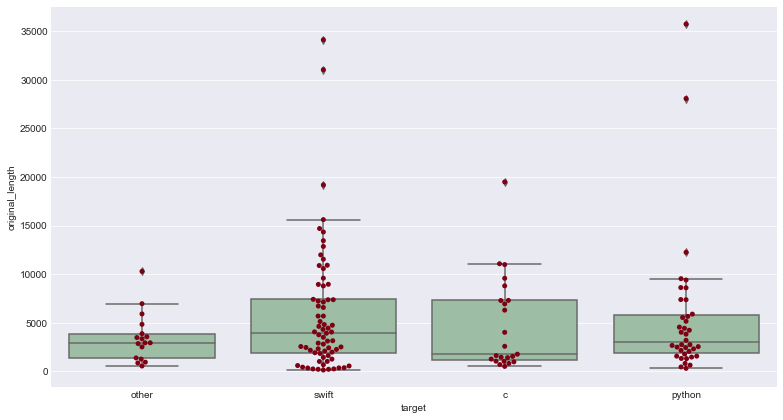

In [70]:
ax = sns.boxplot(x='target', y='original_length', data=df, color='#99c2a2')
ax = sns.swarmplot(x="target", y="original_length", data=df, color='#7d0013')
plt.show()

Perform ANOVA test to compare means of four groups

In [ ]:
#! pip install bioinfokit

In [72]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df, res_var='original_length', anova_model='original_length ~ C(target)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(target),3.0,8.771741e+07,2.923914e+07,0.794414,0.4989
Residual,143.0,5.263248e+09,3.680593e+07,NaN,NaN


P > 0.05 so we fail to reject the null hypotheses. There is no significant difference in average readme length by language

---

## Modeling

### Split Data

Our number of repositories is relatively small (147). We pulled all available Apple repos so this is the upper limit of our available data. 

Ideally, we would like to have two out of sample datasets (validate and test), but this will likely make our training dataset too small.

Instead, we will just do a train and test split and use k-fold cross-validation for model tuning. This allows us to get a feel for the degree of overfitting without having additional out-of-sample datasets.

### Split X/y

Let x be the TFID vectorization of our lemmatized words
Y is the target language family

In [22]:
# Split X Y
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.target


### Train Test Split

- 20% test
- Stratify on target

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

## Baseline

Since sqift was the most frequent language present in our `README`s the baseline will label every `README` as swift.



In [24]:
# baseline
df[df['language'] == 'Swift'].language.value_counts()/sum(df.language.value_counts())

Swift    0.472603
Name: language, dtype: float64

We will add a baseline column to our training evaluation dataframe to compute summary statistics on baseline performance.

In [25]:
#Create evaluation dataframe
train = pd.DataFrame(dict(actual=y_train))
train['baseline']='swift'
# Calculate baseline model performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.baseline)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.baseline, train.actual))
print('---')
print(classification_report(train.actual, train.baseline))

Accuracy: 47.01%
---
Confusion Matrix
actual     c  other  python  swift
baseline                          
swift     18     14      30     55
---
              precision    recall  f1-score   support

           c       0.00      0.00      0.00        18
       other       0.00      0.00      0.00        14
      python       0.00      0.00      0.00        30
       swift       0.47      1.00      0.64        55

    accuracy                           0.47       117
   macro avg       0.12      0.25      0.16       117
weighted avg       0.22      0.47      0.30       117



/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Create models

We ran 25 different models using 7 algorithms and tuned and optimized hyperparameters. Here we will show a subset of these models

### Logistic Regression Model 

In [26]:
# Make and fit the object
lm = LogisticRegression().fit(X_train, y_train)
# Use it to make predictions
train['lm_predicted'] = lm.predict(X_train)
# Asssess accuracy
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))

Accuracy: 81.20%
---
Confusion Matrix
actual        c  other  python  swift
lm_predicted                         
c             9      0       0      0
other         0      2       0      0
python        0      0      29      0
swift         9     12       1     55
---
              precision    recall  f1-score   support

           c       1.00      0.50      0.67        18
       other       1.00      0.14      0.25        14
      python       1.00      0.97      0.98        30
       swift       0.71      1.00      0.83        55

    accuracy                           0.81       117
   macro avg       0.93      0.65      0.68       117
weighted avg       0.87      0.81      0.78       117



Perform 5-fold cross validation to look for overfitting

In [27]:
cross_val_score(lm, X_train, y_train, cv = 5)

array([0.625     , 0.625     , 0.69565217, 0.65217391, 0.65217391])

Fairly large spread of values = Signs of overfitting

### Decision Tree

In [28]:
# Make and fit the object
dtc = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
# Use the object
train['dt_predicted'] = dtc.predict(X_train)
# Determine performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.dt_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.dt_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.dt_predicted))

Accuracy: 75.21%
---
Confusion Matrix
actual        c  other  python  swift
dt_predicted                         
c             3      0       0      0
other         9     10       5      4
python        2      2      24      0
swift         4      2       1     51
---
              precision    recall  f1-score   support

           c       1.00      0.17      0.29        18
       other       0.36      0.71      0.48        14
      python       0.86      0.80      0.83        30
       swift       0.88      0.93      0.90        55

    accuracy                           0.75       117
   macro avg       0.77      0.65      0.62       117
weighted avg       0.83      0.75      0.74       117



Perform 5-fold cross validation to look for overfitting


In [29]:
cross_val_score(dtc, X_train, y_train, cv = 4)

array([0.66666667, 0.68965517, 0.72413793, 0.44827586])

Fairly large spread of values = Signs of overfitting

### Random Forest

In [30]:
# Make and fit object
rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 8, 
                            random_state = 123).fit(X_train, y_train)
# Use it to make predictions
train['rf_predicted'] = rf.predict(X_train)
# Assess performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))

Accuracy: 78.63%
---
Confusion Matrix
actual         c  other  python  swift
rf_predicted                          
c              6      0       0      0
other          0      2       0      0
python         1      3      29      0
swift         11      9       1     55
---
              precision    recall  f1-score   support

           c       1.00      0.33      0.50        18
       other       1.00      0.14      0.25        14
      python       0.88      0.97      0.92        30
       swift       0.72      1.00      0.84        55

    accuracy                           0.79       117
   macro avg       0.90      0.61      0.63       117
weighted avg       0.84      0.79      0.74       117



Perform 5-fold cross validation to look for overfitting


In [31]:
cross_val_score(rf, X_train, y_train, cv = 4)

array([0.66666667, 0.65517241, 0.65517241, 0.62068966])

Values close, likely minimal overfitting

### Knn

In [32]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(X_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 80.34%
---
Confusion Matrix
actual         c  other  python  swift
knn_predicted                         
c              8      1       0      3
other          1      9       0      3
python         3      1      29      1
swift          6      3       1     48
---
              precision    recall  f1-score   support

           c       0.67      0.44      0.53        18
       other       0.69      0.64      0.67        14
      python       0.85      0.97      0.91        30
       swift       0.83      0.87      0.85        55

    accuracy                           0.80       117
   macro avg       0.76      0.73      0.74       117
weighted avg       0.79      0.80      0.79       117



Perform 5-fold cross validation to look for overfitting


In [33]:
cross_val_score(knn, X_train, y_train, cv = 4)

array([0.66666667, 0.68965517, 0.75862069, 0.75862069])

Values close, likely minimal overfitting

### Support Vector Classifier


In [34]:
# Make and fit the object
svc = LinearSVC(random_state=0).fit(X_train, y_train)
# Use the object
train['svc_predicted'] = svc.predict(X_train)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.svc_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.svc_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.svc_predicted))


Accuracy: 99.15%
---
Confusion Matrix
actual          c  other  python  swift
svc_predicted                          
c              17      0       0      0
other           0     14       0      0
python          0      0      30      0
swift           1      0       0     55
---
              precision    recall  f1-score   support

           c       1.00      0.94      0.97        18
       other       1.00      1.00      1.00        14
      python       1.00      1.00      1.00        30
       swift       0.98      1.00      0.99        55

    accuracy                           0.99       117
   macro avg       1.00      0.99      0.99       117
weighted avg       0.99      0.99      0.99       117



Perform 5-fold cross validation to look for overfitting


In [35]:
cross_val_score(svc, X_train, y_train, cv = 4)

array([0.73333333, 0.72413793, 0.82758621, 0.68965517])

Different values - likely overfit

### Modeling Conclusions

- All of our models offer significant improvement from baseline accuracy.
- Many of the algorithms are prone to severe overfitting
  - This problem may be exacerbated by our relatively small number of repositories (Easier for the algorithm to "memorize" fewer answers.)
- Based on a balance of evaluated accuracy and performance on cross-validation, we are moving forward with the **KNN model** with a **K of 4** to test.

---

## Test model

In [38]:
# Create testing dataframe
test = pd.DataFrame(dict(actual=y_test))
test['knn_predicted'] = knn.predict(X_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

Accuracy: 76.67%
---
Confusion Matrix
actual         c  other  python  swift
knn_predicted                         
c              3      1       0      0
python         1      0       6      0
swift          1      2       2     14
---
              precision    recall  f1-score   support

           c       0.75      0.60      0.67         5
       other       0.00      0.00      0.00         3
      python       0.86      0.75      0.80         8
       swift       0.74      1.00      0.85        14

    accuracy                           0.77        30
   macro avg       0.59      0.59      0.58        30
weighted avg       0.70      0.77      0.72        30



/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There are only 30 observations in our testing set, so the penalties for any misclassification is pretty severe.



In [39]:
# Calculate percent improvement from baseline accuracy (47%)
pct_improvement = round(((76.67-47.01)/(47.01)*100), 2)
print(f'Our 76.67% accuracy represent a {pct_improvement}% improvement from baseline')

Our 76.67% accuracy represent a 63.09% improvement from baseline


---

## Conclusions

- Our 76.67% accuracy represent a 63.09% improvement from baseline
- This is a solid effort for a proof of concept project.
- Many algorithms were working at 95%-100% accuracy on the training set, but this was due to gross overfitting.
- Given out 140 README files was on the lower end of the spectum, having more READMES to train on would likely improve our models.
- Keep in mind - this model is only tuned and trained to work on the Apple READMES
  - It will likely perform well on future Apple uploads.
  - It will likely perform poorly on ant REAMDEs from other sources.

---

## Next Steps

- Since we can't make Apple push more to their github, we could potentially look for a family of similar repositories to add to the training sets to increase the size of the corpus will likely increase performance.
- Some of the models that were overfit may prove useful or better than our current best performing model with continued hyperparameter tuning.
- There was an imbalance in the categories in training (47%/26%/16%/11%)
  - Some type of oversampling technique may be helpful in improving models
- We should look at the misclassified items in out final test and see what the actual language is in order to see if any of the 'other' langues are disproportionately responsible for mismatches.
- Look at receiver operator curves and area under the curve for model performance evaluation.

---

### If you made it this far, thank you for your time and attention!